# Trabajo 3 - Esteban Garcia
Misc functions

In [0]:
import torch
from  torch.utils.data import random_split
from  torch.utils.data import Dataset
from  torch.utils.data import TensorDataset
from torch.distributions import normal
from torch.distributions import multivariate_normal
import numpy as np
import math
import matplotlib.pyplot as plt

def separableData(numSamples, plot):
  (targets1, samplesClass1) = createData(numSamples, means = [10.0, 20.0], stds = [2.0, 2.0], targetMultiplier = 1)
  (targets0, samplesClass0) = createData(numSamples, means = [20.0, 10.0],   stds = [2.0, 2.0], targetMultiplier = 0)

  if plot:
    plt.scatter(samplesClass1[:, 1], samplesClass1[:, 2], c="red");
    plt.scatter(samplesClass0[:, 1], samplesClass0[:, 2], c="blue");
    plt.show();
  
  return (samplesClass1, samplesClass0)

def notSeparableData(numSamples, plot):
  (targets1, samplesClass1) = createData(numSamples, means = [10.0, 15.0], stds = [5.0, 2.0], targetMultiplier = 1)
  (targets0, samplesClass0) = createData(numSamples, means = [18.0, 19.0], stds = [5.0, 2.0], targetMultiplier = 0)
  
  if plot:
    plt.scatter(samplesClass1[:, 1], samplesClass1[:, 2], c="red");
    plt.scatter(samplesClass0[:, 1], samplesClass0[:, 2], c="blue");
    plt.show();  
  
  return (samplesClass1, samplesClass0)

def createData(numberSamples = 2, means = [2.0, 2.0], stds = [2.0, 1.0], targetMultiplier = 1):
    
    means = torch.tensor(means)

    # Ones to concatenate for bias
    ones = torch.rand(numberSamples, 1)
    
    # Covariance matrix creation with identity
    covarianceMatrix = torch.eye(2)
    covarianceMatrix[0, 0] = stds[0]
    covarianceMatrix[1, 1] = stds[1]

    # Inits the bi gaussian data generator
    multiGaussGenerator = multivariate_normal.MultivariateNormal(means, covarianceMatrix)
    # Takes the samples
    samplesClass = multiGaussGenerator.sample(torch.Size([numberSamples]))
    
    # Concatenates the ones for the bias
    samplesClassBias = torch.cat((ones, samplesClass), 1)
    
    #Create targets
    targets = targetMultiplier * torch.ones(numberSamples, 1)
    
    return (targets, samplesClassBias)
  
def evaluateSample(m, w):
  return torch.sigmoid(torch.mm(m, w))

def clasifySample(m, w):
  return torch.sigmoid(torch.mm(m, w)) >= 0.5

def printTable(table):
  col_width = max(len(word) for row in table for word in row) + 2  # padding
  for row in table:
      print("".join(word.ljust(col_width) for word in row))
  
def splitSamples(samples, lenghts):
  dataset = TensorDataset(samples)
  
  trainingDataset, testingDataset = random_split(dataset, lengths)
  
  trainingSamples  = dataset[trainingDataset.indices][0] 
  testingSamples   = dataset[testingDataset.indices][0]
  
  return (trainingSamples, testingSamples)

# Algoritmo de Regresión logística
**1.2.a) Implemente el algoritmo de regresion logistica**

---Prueba de regresosr logistico---


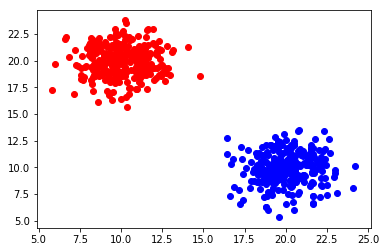

Error:  0
Epoch:  2
W:      tensor([[  -1.4869],
        [ 300.0802],
        [-299.8705]])
Test Class 0:  tensor([[0],
        [0],
        [0],
        [0],
        [0]], dtype=torch.uint8)
Test Class 1:  tensor([[1],
        [1],
        [1],
        [1],
        [1]], dtype=torch.uint8)


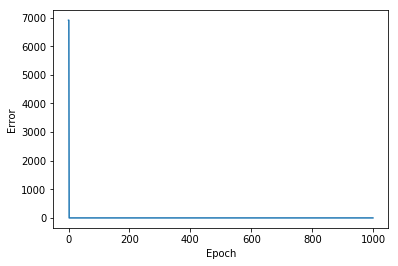

In [2]:
def getDeltaWeightsForClass(W, Samples, alpha, target):

    evaluatedSamples = torch.sigmoid(torch.mm(Samples, W)) 
    LOW_VAL = 1e-10    
      
    DeltaWeightsWithAlpha = alpha * torch.mm(Samples.transpose(0, 1), target - evaluatedSamples)
    
    error = -torch.sum((target * torch.log(evaluatedSamples + LOW_VAL)) + ((1 - target) * torch.log((1.0 - evaluatedSamples) + LOW_VAL)))
    
    return (DeltaWeightsWithAlpha, error);
  
  
def train(samplesClass0, samplesClass1, numIter, alpha):
    dimensionsData = samplesClass1.size();
    W = torch.randn(dimensionsData[1],1);
    errorPerEpoch = [0] * numIter;
    lastIteration = 0

    for i in range(0, numIter):        
        #Change of weights calculated given the samples in class 1
        (DeltaWeights0, error0) = getDeltaWeightsForClass(W, samplesClass0, alpha, target = 0.0);
        
        # Change of weights calculated given the samples in class 2
        (DeltaWeights1, error1) = getDeltaWeightsForClass(W, samplesClass1, alpha, target = 1.0);
        
        #total error for both classes
        error = error0 + error1
        errorPerEpoch[i] = error;
                      
        W = W + DeltaWeights0 + DeltaWeights1    
        
        lastIteration = i
        if(error < 0.001):          
          break
        
    return (W, errorPerEpoch, lastIteration); 
  
def main():
  
    #torch.manual_seed(10)
  
    numIterations = 1000;
    numSamples = 300
    alpha = 0.1;
    
    print("---Prueba de regresosr logistico---")
  
    (samplesClass0, samplesClass1) = separableData(numSamples, True);
    (W, errorPerEpoch, lastIteration) = train(samplesClass0, samplesClass1, numIterations, alpha);
    
    (testClass0, testClass1) = separableData(5, False);
    
    print("Error: ",  errorPerEpoch[numIterations -1])
    print("Epoch: ",  lastIteration)    
    print("W:     ",  W)
    print("Test Class 0: ", clasifySample(testClass0, W))    
    print("Test Class 1: ", clasifySample(testClass1, W))
       
    #plot the error per epoch
    plt.plot(errorPerEpoch)
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.show()
    
main();

**1.2.b) Cuál de las funciones matemáticas vistas en clase puede utilizarse a la salida del regresor logístico para realizar una clasificación binaria? Explique cómo modificar la regresión logística entonces para realizar una clasificación binaria**

*R/ Se puede definir una funcion discontinua para hacer que el regresor logístico sea un clasificador binario. La modificacion consiste en definir una funcion a trozos de manera que: $y(m)\geq u\Rightarrow t=1$ y si $y(m)< u\Rightarrow t=0$* y usarla para evaluar la salida del regresor

**1.2.c) Realice 2 pruebas con distintas distancias de separación entre las muestras de las clases, con una prueba linealmente separable, y otra no, y documente el número (en una tabla) de muestras mal clasificadas y la cantidad de iteraciones para converger.**

*R/En las tablas se aprecia como en el caso linealmente separable el regresor rapidamente logra converger, sin embargo, en el caso no separable el regresor no converge y siempre mantiene un error elevado.*


------Prueba con clases linealmente separables------



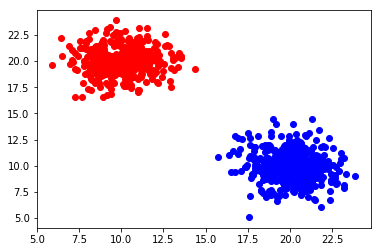

Run                 Clasif. Err.        Train Err.          Epoch               
0                   0/120               -0.0                2                   
1                   0/120               -0.0                2                   
2                   0/120               -0.0                6                   
3                   0/120               -0.0                3                   
4                   0/120               -0.0                1                   
5                   0/120               -0.0                2                   
6                   0/120               -0.0                5                   
7                   0/120               -0.0                2                   
8                   0/120               -0.0                2                   
9                   0/120               -0.0                2                   
Mean:               0.0                 0.0                 2.7                 
Std:                0.0     

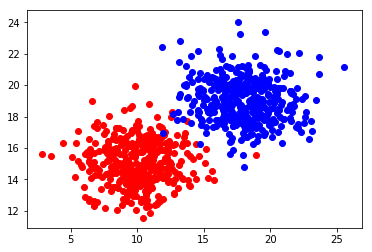

Run                 Clasif. Err.        Train Err.          Epoch               
0                   69/120              2854.278076171875   1999                
1                   61/120              3384.009765625      1999                
2                   60/120              2731.2509765625     1999                
3                   64/120              3216.92919921875    1999                
4                   52/120              3584.257568359375   1999                
5                   58/120              2840.36474609375    1999                
6                   58/120              2812.22705078125    1999                
7                   67/120              2735.978759765625   1999                
8                   60/120              2906.698486328125   1999                
9                   70/120              2730.03662109375    1999                
Mean:               61.9                2979.603125         1999.0              
Std:                5.318834

In [3]:
numIterations = 2000;
numSamples = 400
alpha = 0.05;
lengths = [int(numSamples * 0.7), int(numSamples *0.3)]





print("\n------Prueba con clases linealmente separables------\n")

table = [["Run","Clasif. Err.", "Train Err.", "Epoch"]]
(samplesClass0, samplesClass1) = separableData(numSamples, True);

errorPerRun = []
lastEpochs = []
trainErr = []

for i in range(0, 10):
  
  (trainSamples0, testSamples0) = splitSamples(samplesClass0, lengths)
  (trainSamples1, testSamples1) = splitSamples(samplesClass1, lengths)

  (W, errorPerEpoch, epoch) = train(trainSamples0, trainSamples1, numIterations, alpha);

  error = torch.sum(clasifySample(testSamples0, W), dim = 0) + \
          int(numSamples * 0.3) - torch.sum(clasifySample(testSamples1, W), dim = 0)
  
  errorPerRun.append(error)
  lastEpochs.append(epoch)
  trainErr.append(errorPerEpoch[epoch].item())

  table.append([str(i), str(error.item()) + "/" +str(int(numSamples * 0.3)), str(errorPerEpoch[epoch].item()), str(epoch)])

table.append(["Mean:", str(np.mean(errorPerRun)), str(np.mean(trainErr)), str(np.mean(lastEpochs))])
table.append(["Std: ", str(np.std(errorPerRun)), str(np.std(trainErr)), str(np.std(lastEpochs))])
printTable(table)





print("\n------Prueba con clases no linealmente separables------\n")

table = [["Run","Clasif. Err.", "Train Err.", "Epoch"]]
(samplesClass0, samplesClass1) = notSeparableData(numSamples, True);

errorPerRun = []
lastEpochs = []
trainErr = []

for i in range(0, 10):
  
  (trainSamples0, testSamples0) = splitSamples(samplesClass0, lengths)
  (trainSamples1, testSamples1) = splitSamples(samplesClass1, lengths)

  (W, errorPerEpoch, epoch) = train(trainSamples0, trainSamples1, numIterations, alpha);

  error = torch.sum(clasifySample(testSamples0, W), dim = 0) + \
          int(numSamples * 0.3) - torch.sum(clasifySample(testSamples1, W), dim = 0)
  
  errorPerRun.append(error)
  lastEpochs.append(epoch)
  trainErr.append(errorPerEpoch[epoch].item())

  table.append([str(i), str(error.item()) + "/" +str(int(numSamples * 0.3)), str(errorPerEpoch[epoch].item()), str(epoch)])

table.append(["Mean:", str(np.mean(errorPerRun)), str(np.mean(trainErr)), str(np.mean(lastEpochs))])
table.append(["Std: ", str(np.std(errorPerRun)), str(np.std(trainErr)), str(np.std(lastEpochs))])
printTable(table)






# Experimentos, análisis y el enfoque de mínimos cuadrados regularizado

**2.1) Genere una función como la mostrada en la ecuación $t= sin (2πx) +e(x)$ en la que el seno se contamine con ruido Gaussiano, con relación señal a ruido de 4 dB (puede usar la función awgn para contaminar con ruido Gaussiano tal señal unidimensional).**

>**2.1.a) Utilice dos conjuntos de datos con $N= 10$ y $N= 100$ para todos los puntos posteriores.**

>**2.1.b) Grafique la salida de la función $t$ en el intervalo $[0, 1]$, usando la función scatter de pyhon**

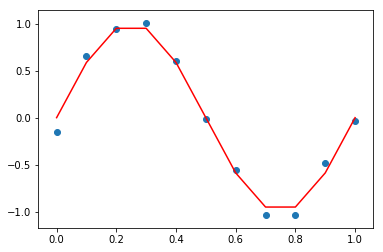

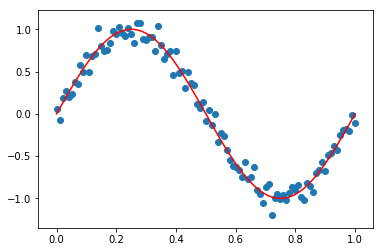

In [4]:
def generateValueArray(min, max, quantity):
  array = np.arange(min, max, 1/(quantity/max))
  #To always have the max value
  #array[array.size - 1] = max
  array = np.append(array, max)
  return array

def generateTY(x, stdNoise):

    y = np.sin(2* np.pi * x);
    #create noise
    noise = np.random.normal(0, stdNoise, y.shape);
    #additive gaussian noise                        
    t = y + noise;
    return (t, y);
  
x10 = generateValueArray(0, 1, 10)
(t10, y10) = generateTY(x10, 0.1)

#scatter of the noisy signal
plt.plot(x10, y10, c="red")
plt.scatter(x10, t10)
plt.show()

x100 = generateValueArray(0, 1, 100)
(t100, y100) = generateTY(x100, 0.1)

#scatter of the noisy signal
plt.plot(x100, y100, c="red")
plt.scatter(x100, t100)
plt.show()

**2.2) Programe la función $getOptimum(\vec{x},\overrightarrow{t},M)$, la cual obtenga el arreglo óptimo de pesos $\overrightarrow{w}_{opt}$ usando el enfoque de mínimos cuadrados, donde $D=\{\overrightarrow{x},\overrightarrow{t}\}$ es el conjunto de datos de entrenamiento obtenidos en el punto anterior.**


In [0]:
def generateX(x, M):
  
  X = torch.ones(x.size, M + 1)
  xTensor = torch.tensor(x)
  
  for i in range(1, M + 1):  
    X[:,i] = xTensor**i 
  
  return X

def getOptimum(x, t, M):
  
  X = generateX(x, M)
  
  Xpinv = torch.tensor(np.linalg.pinv(X.numpy()))
  tTensor = torch.tensor(t).reshape((t.size, 1)).float()

  w = Xpinv.mm(tTensor)

  return (w, X)


def evaluate(w, X):
  
  r = w.t().mm(X.t())[0].numpy()
  
  return r

def EwRMS(w, X, t):
  
  tTensor = torch.tensor(t).reshape((t.size, 1)).float()  
  Ew = torch.dist(w.t().mm(X.t())[0], tTensor[:,0])
  return math.sqrt((2 * Ew) / t.size)


**2.2.a) Experimente con al menos cuatro valores distintos de $M$, grafique el modelo resultante y la función sin ruido, y explique el fenómeno de sobreajuste.**

*R\ En casos donde $N = 10$ se aprecia claramente como el modelo se apega más a los valores de entrenamiento conforme el valor de $M$ se aumenta, es decir, el error del entrenamiento disminuye. A su vez esto ocasiona que el modelo se sobreajuste a las observaciones iniciales y no haga generalización del modelo, esto se puede ver pues al evaluar con el conjunto de pruebas el error no disminuye conforme $M$ aumenta*

**2.2.b) Presente una tabla por cada valor de $M$ en la que se evalúe el error RMS, tanto para el conjunto de datos de entrenamiento (70 %), como el de validación (30%) como soporte para la explicación solicitada anteriormente.**




--------------------------------- Usando 10 Muestras ---------------------------------



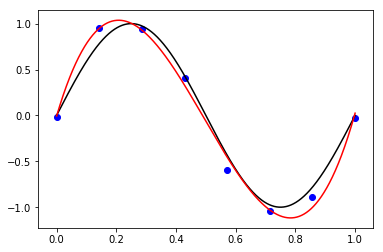

M:  3  EwRMS Train:  0.22567381530204392  EwRMS Test:  0.4253401965471487


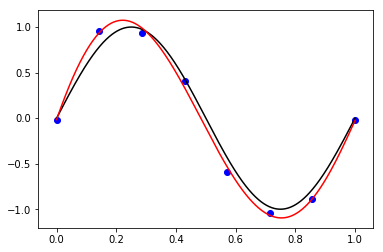

M:  5  EwRMS Train:  0.17043357294739164  EwRMS Test:  0.44067609369007305


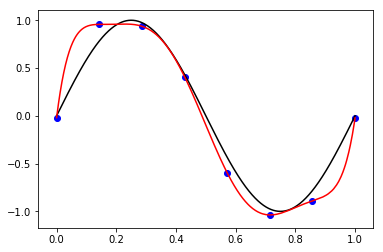

M:  7  EwRMS Train:  0.020363918060823924  EwRMS Test:  0.45062726661757563


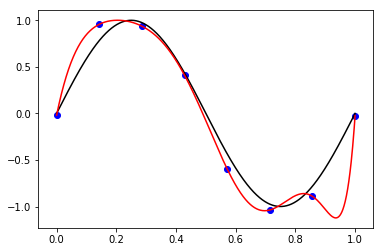

M:  11  EwRMS Train:  0.005126919419881747  EwRMS Test:  0.4683315634722318


---------------------------------Summary N = 10---------------------------------

M                     EwRMS Train (70%)     EwRMS Test (30%)      
3                     0.22567381530204392   0.4253401965471487    
5                     0.17043357294739164   0.44067609369007305   
7                     0.020363918060823924  0.45062726661757563   
11                    0.005126919419881747  0.4683315634722318    



--------------------------------- Usando 100 Muestras ---------------------------------



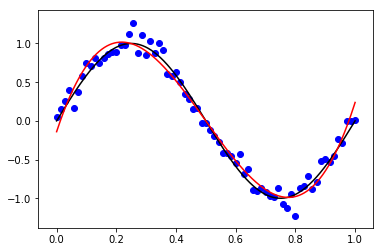

M:  3  EwRMS Train:  0.1654549218019978  EwRMS Test:  0.21741142461665727


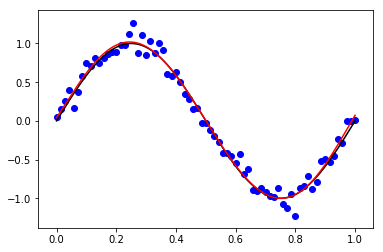

M:  5  EwRMS Train:  0.15040688612577718  EwRMS Test:  0.20011725415852866


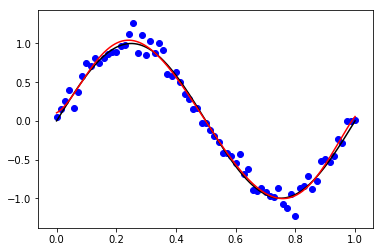

M:  7  EwRMS Train:  0.14917205709124828  EwRMS Test:  0.20059894716441976


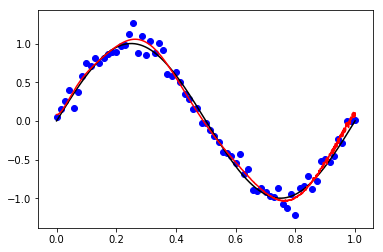

M:  11  EwRMS Train:  0.14552015853835518  EwRMS Test:  0.20536946991239047


---------------------------------Summary N = 100---------------------------------

M                    EwRMS Train (70%)    EwRMS Test (30%)     
3                    0.1654549218019978   0.21741142461665727  
5                    0.15040688612577718  0.20011725415852866  
7                    0.14917205709124828  0.20059894716441976  
11                   0.14552015853835518  0.20536946991239047  


In [6]:
x7 = generateValueArray(0, 1, 7)
(t7, y7) = generateTY(x7, 0.1)

x3 = generateValueArray(0, 1, 3)
(t3, y3) = generateTY(x3, 0.1)

x70 = generateValueArray(0, 1, 70)
(t70, y70) = generateTY(x70, 0.1)

x30 = generateValueArray(0, 1, 30)
(t30, y30) = generateTY(x30, 0.1)

#x: x values
#t: observation
#y: real y (for ploting)
#M: polinomial degree
def trainAndPlotModelM(x, t, y, M, xTest, tTest):
  
  #Weigths and X^j matrix
  (w, X) = getOptimum(x, t, M)
  #y estimated
  yEst = evaluate(w, X)
  
  XTest = generateX(xTest, M)
  
  EwTrain = EwRMS(w, X, t)
  EwTest = EwRMS(w, XTest, tTest) 
  
  #
  x1000 = generateValueArray(0, 1, 1000)
  (dummy, y) = generateTY(x1000, 0.2)
  X1000 = generateX(x1000, M)
  y1000 = evaluate(w, X1000)  
  #
  
  
  #plt.plot(x, y, c="black")
  plt.plot(x1000, y, c="black")
  plt.plot(x1000, y1000, c="red")
  plt.scatter(x, t, c="blue")
  #plt.plot(x, yEst, c="red")
  plt.show()
  
  print("M: ", M, " EwRMS Train: " , EwTrain, " EwRMS Test: ", EwTest)
  
  return [str(M), str(EwTrain), str(EwTest)]


print("\n\n\n--------------------------------- Usando 10 Muestras ---------------------------------\n")

results10 = [["M", "EwRMS Train (70%)", "EwRMS Test (30%)"]]
  
results10.append(trainAndPlotModelM(x7, t7, y7, 3, x3, t3))

results10.append(trainAndPlotModelM(x7, t7, y7, 5, x3, t3))

results10.append(trainAndPlotModelM(x7, t7, y7, 7, x3, t3))

results10.append(trainAndPlotModelM(x7, t7, y7, 11, x3, t3))

print("\n\n---------------------------------Summary N = 10---------------------------------\n")
printTable(results10)

print("\n\n\n--------------------------------- Usando 100 Muestras ---------------------------------\n")

results100 = [["M", "EwRMS Train (70%)", "EwRMS Test (30%)"]]
  
results100.append(trainAndPlotModelM(x70, t70, y70, 3, x30, t30))

results100.append(trainAndPlotModelM(x70, t70, y70, 5, x30, t30))

results100.append(trainAndPlotModelM(x70, t70, y70, 7, x30, t30))

results100.append(trainAndPlotModelM(x70, t70, y70, 11, x30, t30))

print("\n\n---------------------------------Summary N = 100---------------------------------\n")
printTable(results100)



**2.3) Para atenuar el problema de sobre-ajuste, el enfoque de mínimos cuadrados regularizados propone agregar un término que «castigue» los vectores de pesos $w$ con dimensionalidad alta, sumando la norma de $w$ y pesada por el parámetro de regularización $lambda$**

**Implemente el enfoque de mínimos cuadrados regularizado por el parámetro λ, y pruebe al menos tres valores distintos para tal parámetro (con
uno de ellos λ = 0), con dos conjuntos de datos de $N= 10$ y $N = 100$.** 

>**a) Grafique el modelo resultante para cada variante, junto con la función sin ruido.**

>**b) Evalúe la función de error RMS para cada caso, y presente una tabla con los tres valores de λ y los dos valores de N escogidos.**

>**c) Explique el comportamiento observado, y relaciones la manipulación de λ respecto a $M$ en el apartado anterior, y la cantidad de datos $N$. ¿Qué relación encuentra entre λ y $N$?**

>*R/ La regularizacion parece dar mejores resultados con $N$ mas altos. En general con $lambda = 0$ hay una tendencia a mostrar sobreajuste y conforme el $lambda$ se aumenta lo contrario sucede y el modelo no logra ajustarse a las observaciones. En este caso parece que un valor de $lambda$ muy cercano a 0 ayuda a reducir el error*




--------------------------------- Usando 10 Muestras ---------------------------------



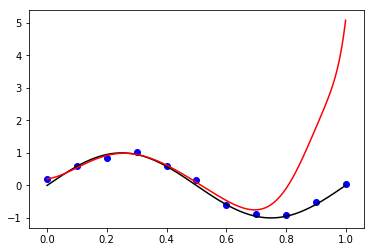

M:  17 Lambda:  0  EwRMS Train:  1.008554761917547


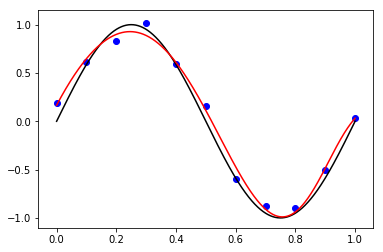

M:  17 Lambda:  0.0001  EwRMS Train:  0.19631855301875195


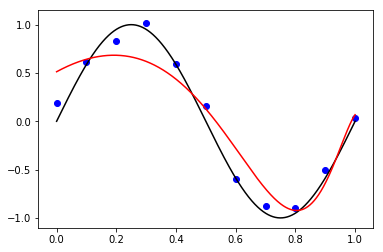

M:  17 Lambda:  0.01  EwRMS Train:  0.3523887884616249



--------------------------------- Usando 100 Muestras ---------------------------------



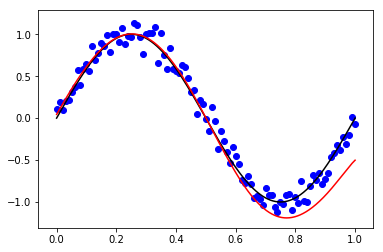

M:  17 Lambda:  0  EwRMS Train:  0.19338802163975474


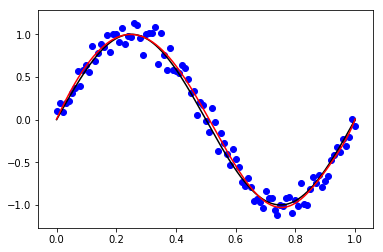

M:  17 Lambda:  0.0001  EwRMS Train:  0.13893849973623498


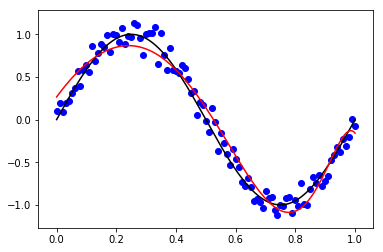

M:  17 Lambda:  0.01  EwRMS Train:  0.1655272987388167


---------------------------------Summary N = 100---------------------------------

N                    M                    Lambda               EwRMS                
10                   17                   0                    1.008554761917547    
10                   17                   0.0001               0.19631855301875195  
10                   17                   0.01                 0.3523887884616249   
100                  17                   0                    0.19338802163975474  
100                  17                   0.0001               0.13893849973623498  
100                  17                   0.01                 0.1655272987388167   


In [7]:
def getOptimumReg(x, t, M, lam):
  
  X = generateX(x, M)
  
  tTensor = torch.tensor(t).reshape((t.size, 1)).float()

  XtXLI = (X.t().mm(X)) + (lam * torch.eye(M + 1)) 
  w = torch.tensor(np.linalg.pinv(XtXLI.numpy())).mm(X.t()).mm(tTensor)

  return (w, X)

x10 = generateValueArray(0, 1, 10)
(t10, y10) = generateTY(x10, 0.1)

x100 = generateValueArray(0, 1, 100)
(t100, y100) = generateTY(x100, 0.1)


#x: x values
#t: observation
#y: real y (for ploting)
#M: polinomial degree
def trainAndPlotModelM(x, t, y, M, lam):
  
  #Weigths and X^j matrix
  (w, X) = getOptimumReg(x, t, M, lam)
  #y estimated
  yEst = evaluate(w, X)
  
  EwTrain = EwRMS(w, X, t)
  
  #
  x1000 = generateValueArray(0, 1, 1000)
  (dummy, y1000) = generateTY(x1000, 0.1)
  X1000 = generateX(x1000, M)
  yEst1000 = evaluate(w, X1000)  
  #
  
  plt.plot(x1000, y1000, c="black")
  plt.plot(x1000, yEst1000, c="red")
  plt.scatter(x, t, c="blue")
  plt.show()
  
  print("M: ", M, "Lambda: ", lam, " EwRMS Train: " , EwTrain)
  
  return [str(t.size - 1), str(M), str(lam), str(EwTrain)]


print("\n\n\n--------------------------------- Usando 10 Muestras ---------------------------------\n")

results = [["N", "M", "Lambda","EwRMS"]]

  
results.append(trainAndPlotModelM(x10, t10, y10, 17, 0))

results.append(trainAndPlotModelM(x10, t10, y10, 17, 1e-4))

results.append(trainAndPlotModelM(x10, t10, y10, 17, 1e-2))


print("\n\n\n--------------------------------- Usando 100 Muestras ---------------------------------\n")

  
results.append(trainAndPlotModelM(x100, t100, y100, 17, 0))

results.append(trainAndPlotModelM(x100, t100, y100, 17, 1e-4))

results.append(trainAndPlotModelM(x100, t100, y100, 17, 1e-2))


print("\n\n---------------------------------Summary N = 100---------------------------------\n")
printTable(results)

